<h1><center>Projet Deep Learning: <br/> Analyse de Sentiment</center></h1>
<br/>
<div class='text-danger'><center> Objectif : Déterminer les sentiment d'un tweet</center></div>

## L'objectif du projet
Nous devons utiliser nos connaissances acquises en cours afin de :
* Utiliser le Deep Learning

Dans notre cas, nous avons sélectionné le dataset "Sentiment140". Le but est de déterminer les sentiments qui ressortent d'un tweet grâce au Deep Leaning

## Préparation du Dataset

### Importation des bibliothèques nécessaires à notre projet

In [47]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
import re
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import opendatasets as od
import codecs
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Initialisation du Dataset

In [2]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


In [3]:
file = ('sentiment140/training.1600000.processed.noemoticon.csv')
Data_set = pd.read_csv(file, delimiter=',', encoding='latin1')
  
Data_set.head()



,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Comme nous pouvons le voir, notre dataset n'a pas des noms de colonnes très lisibles, on va donc les renommer.



In [4]:
Data_set.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
Data_set.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Nous n'avons pas besoin des colonnes 'id', 'date', 'query' et 'user_id' puisque nous allons traiter le texte et les sentiments seulement, indépendamment des autres données.

In [5]:
Data_set = Data_set.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
Data_set.sentiment = Data_set.sentiment.apply(lambda x: label_decoder(x))
Data_set.head()

,sentiment,text
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


Regardons la répartition des données du dataset pour être sûr d'avoir bien une bon nombre de chaques classes (ici sentiments négatifs et sentiments positifs).

Text(0.5, 1.0, 'Distribution des données des sentiments')

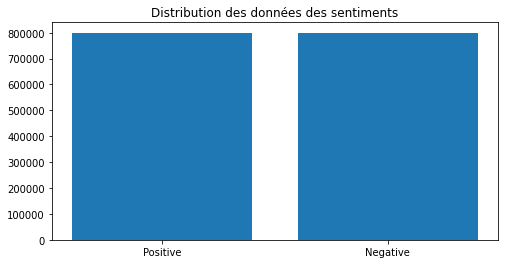

In [7]:
val_count = Data_set.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Distribution des données des sentiments")

On peut voir qu'on a approximativement 50% pour chaque classes, ce qui est parfait.
Voyons maintenant quelques données de notre dataset.

In [8]:
random_idx_list = [random.randint(1,len(Data_set.text)) for i in range(10)] # Créer des index aléatoires à choisir dans notre dataset 
Data_set.loc[random_idx_list,:].head(10) # Renvoi les lignes de nos indexs et les affichent

,sentiment,text
117437,Negative,enjoying a yummy breakfast at Autostrada befor...
1095322,Positive,@okse *Phew* Hate to think you and Colin had f...
1403862,Positive,"Up early... Again... Church retreat, should be..."
1321472,Positive,I finally watched ICAC. Wong Chau Sang is real...
406500,Negative,Working. . Still Haha poor jess
451330,Negative,is done with dinner and now has to do Algebra ...
818156,Positive,"@digitalpaint thank you so much, so sweet"
997720,Positive,I haven't been to sleep yet!! The lake is grea...
295118,Negative,@ebassman Wish I could stay up longer and play...
561365,Negative,"#hdc @Footdr69 shitful day, am sick, might go ..."


Nos textes contiennent des données inutiles tels que les @user, certaines ponctuations, hyperlinks, émoticones etc...
Il va falloir trier tout ça pour avoir un jeu de donnée propre.

### Traitements des données textuels

Nous allons utiliser les principes de "**Stemming**" et "**Lematization**" pour ce faire.
Le principe des deux est de réduire les formes de mots dérivées vers une forme de base commune.

Le "Stemming" est un processus qui coupe la fin des mots.

Le "Lematization" est un processus d'analyse vocabulaire et morphologique des mots, qui a pour but de renvoyer la forme de base d'un mot.

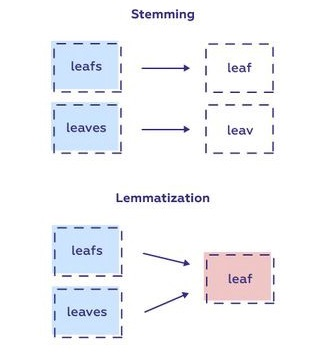

Nous allons également traiter les "Stopwords" qui sont des mots anglais qui n'ont aucune valeur et n'apportes rien au sens d'une phrase.

Par exemple:

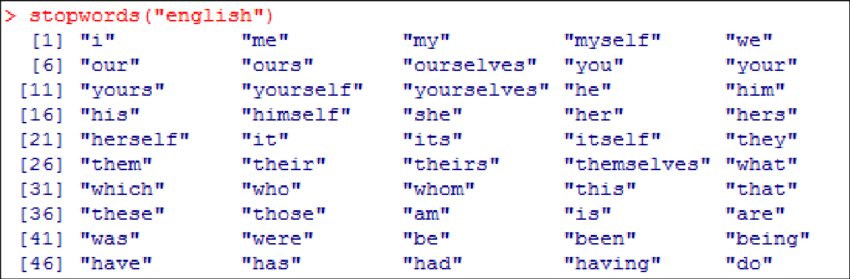

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

re_cleaner = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(re_cleaner, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
Data_set.text = Data_set.text.apply(lambda x: preprocess(x))

Mots **positifs** les plus présents :

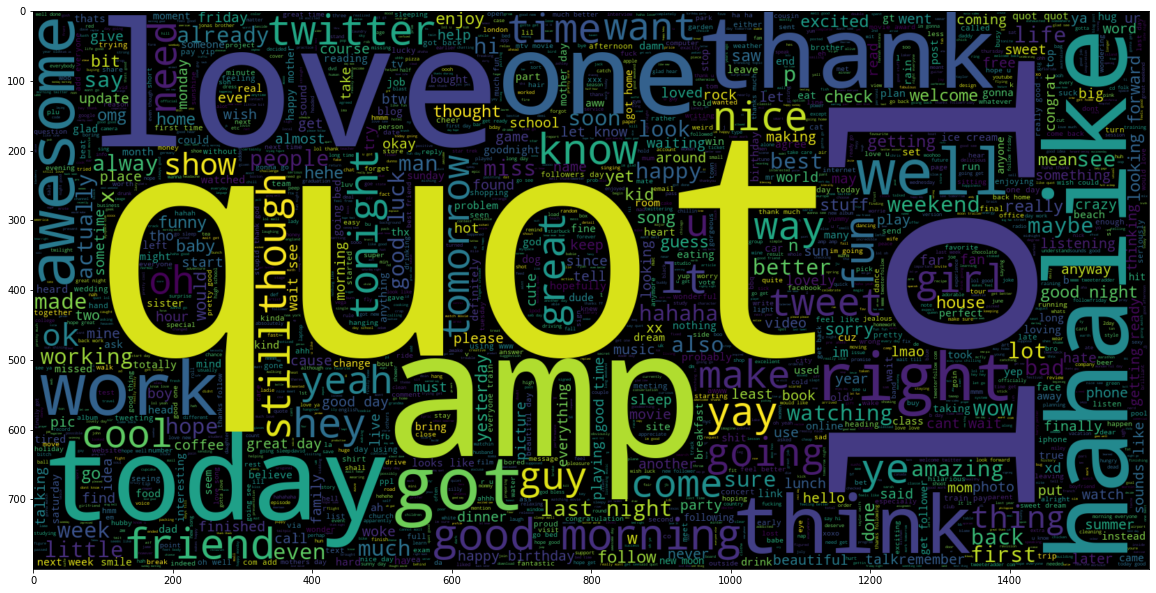

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = stop_words, max_words = 2000 , width = 1600 , height = 800).generate(" ".join(Data_set[Data_set.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

Mots **négatifs** les plus présents :

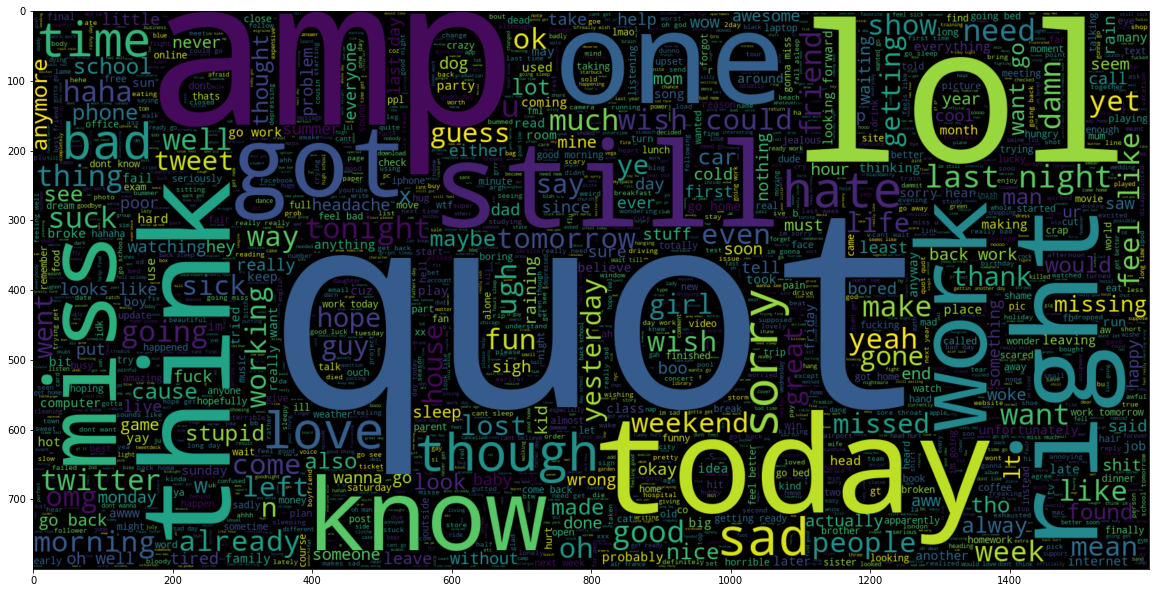

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = stop_words, max_words = 2000 , width = 1600 , height = 800).generate(" ".join(Data_set[Data_set.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Entrainement du modèle

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

Nous allons mélanger notre dataset afin d'avoir un entrainement qualitatif.

In [15]:
train_data, test_data = train_test_split(Data_set, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Partge du dataset en set d'entrainement et de test
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1279999
Test Data size 320000


In [16]:
train_data.head(10)

,sentiment,text
1176709,Positive,lol get coming good way mean way talented authors
641121,Negative,would miss dreaming anymore
1132400,Positive,poletii check following woman ahahha
130866,Negative,im sick thing would make feel better would pal...
1235875,Positive,sounds like cup tea sign
1568154,Positive,think going take hot bath amp listen lvatt
758235,Negative,feel tired today going gym
1446219,Positive,weekend resting peace finally
763239,Negative,sooo jealous hope one day make france go louvr...
584093,Negative,say cry hahah


Nous pouvons donc voir que le dataset d'entrainement est bien mélangé.

### Transformation en Tokens

Le principe de "**Tokenization**" permet de couper une phrase (une séquence de mots (char)) en pièces, appelées "Tokens". Ce processus permet également de se débarasser de certains char tels que les ponctuations, qui nous sont inutiles dans notre cas.

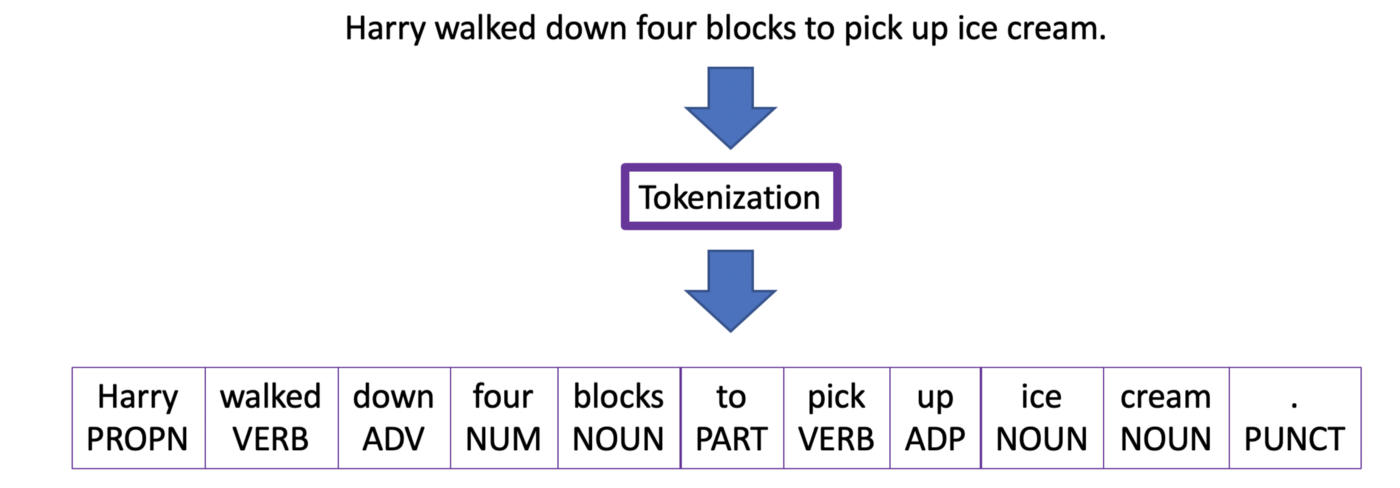

L'objet "tokenizer" créé un token pour chaque mot dans le corpus de donnée et les ajoute dans un dictionnaire.

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ", vocab_size)

Vocab size:  290658


On peut donc maintenant convertir n'importe quel mot en une clé dans le dictionnaire.

On va construire un modèle de séquence. Pour cela, on doit lui fournir une séquence de nombres. Et il faut qu'on fasse attention qu'il n'y ai pas de variance dans la taille des inputs.

Le problème étant que le texte des tweets on pas forcément tous le même nombres de mots. Pour éviter ce problème, on va utiliser *pad_sequence* pour avoir toute les séquences de même taille, MAX_SEQUENCE_LENGHT.



In [18]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1279999, 30)
Testing X Shape: (320000, 30)


In [19]:
labels = train_data.sentiment.unique().tolist()

### Encoder les labels

Notre modèle est une classification binaire (0 ou 1, positif ou négatif), il faut donc que nos labels soit sous formes encodés.

In [20]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


### Embedding des mots

Le principe de "Word Embedding" permet de capturer le context d'un mot selon la phrase dans laquelle il est utilisé, sa sémantique etc...

Dans notre cas, cela va permettre à notre modèle de comprendre plus facilement à quoi correspond chaque mots.

Pour ne pas avoir à entrainer nous même notre système, on va utiliser **Transfer Learning**, ce qui va nous permettre de télécharger un embedding pré-entrainé et l'appliquer à notre modèle.

Nous avons trouvé un Word Embedding pré-entrainé nommé "GloVe" de Stanford AI, et c'est celui que nous allons utilisé.

In [21]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [22]:
embeddings_index = {}

f = codecs.open(GLOVE_EMB, 'r', encoding='utf-8', errors='ignore')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print('Embedding matrix:', embedding_matrix)

Embedding matrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.13602    -0.11594    -0.017078   ... -0.33759999  0.070098
   0.24642   ]
 [-0.24501    -0.12491    -0.2536     ... -0.41073    -0.61926001
   0.0039007 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [24]:
weight = torch.from_numpy(embedding_matrix)
print("weight: ",weight)
embedding_layer = torch.nn.Embedding.from_pretrained(weight)

weight:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1360, -0.1159, -0.0171,  ..., -0.3376,  0.0701,  0.2464],
        [-0.2450, -0.1249, -0.2536,  ..., -0.4107, -0.6193,  0.0039],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)


## Entrainement du modèle en LSTM

Nous allons utiliser des modèles de séquences puisque le problème principal de notre dataset, comme nous pouvons le voir dans notre nuage de mots, est que certains mots sont prédominants à la fois dans les tweets négatifs, et à la fois dans les tweets positifs.

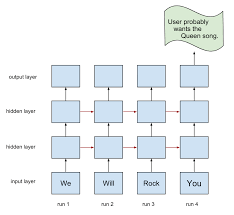

Le réseau de neuronnes va donc sortir une prédiction de valeur scalaire.

Notre modèle aura plusieurs layers:

-L'**Embedding layer** que nous avons déjà créé précédemment. Il va générer un vecteur pour chaque séquence d'entrée.

-Un **Conv1D layer** qui va convoluer les valeurs en vecteur de caractéristiques.

-Le **LSTM** (Long-Short Term Memory), qui est une variante du RNN et qui possède une mémoire pour apprendre le contexte des mots se trouvant plus loin dans le texte et donc donner du sens contextuel plutot que le faire simplement avec ses voisins.

-Un **Dense layer**, qui est un FCL (fully-connected layer), qui nous sera utilie pour la classification.

In [52]:
from turtle import shape


#sequence_input = torch.randn(MAX_SEQUENCE_LENGTH, ).type(torch.int)
sequence_input = torch.zeros(MAX_SEQUENCE_LENGTH, ).type(torch.int)

sequence_input2 = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

print(sequence_input.shape)
print(sequence_input2.shape)

embedding_sequences = embedding_layer(sequence_input)

torch.Size([30])
(None, 30)


IndexError: index out of range in self